In [1]:
import os
os.environ['OPENAI_API_KEY'] = "EXAMPLES"

# 프롬프트
##### 언어 모델에 대한 프롬프트는 모델의 응답을 안내하기 위해 사용자가 제공하는 일련의 지침 또는 입력
##### 모델이 맥락을 이해하고 질문에 대답하거나 문장을 완성하거나 작업에 참여하는 등 관련 있고 일관된 언어 기반 출력을 생성하도록 돕는다.

## Quickstart
##### 프롬프트 템플릿은 언어 모델에 대한 프롬프트를 생성하기 위해 미리 정의된 레시피이다.

### PromptTemplate
##### 문자열 프롬프트에 대한 템플릿을 생성하는데 사용한다.

In [ ]:
!pip install langchain

In [ ]:
!pip install langchain_openai

In [4]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template(
    "Tell me a {adjective} joke about {content}."
)
prompt_template.format(adjective="funny", content="chickens")

'Tell me a funny joke about chickens.'

In [5]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template("Tell me a joke")
prompt_template.format()

'Tell me a joke'

### ChatPromptTemplate
##### ChatModel에 대한 프롬프트는 채팅 메시지 목록이다.
##### 각 채팅 메시지는 콘텐츠라는 추가 매개변수와 연결된다.

In [6]:
from langchain_core.prompts import ChatPromptTemplate

chat_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful AI bot. Your name is {name}."),
        ("human", "Hello, how are you doing?"),
        ("ai", "I'm doing well, thanks!"),
        ("human", "{user_input}"),
    ]
)

messages = chat_template.format_messages(name="Bob", user_input="What is your name?")

In [7]:
messages

[SystemMessage(content='You are a helpful AI bot. Your name is Bob.'),
 HumanMessage(content='Hello, how are you doing?'),
 AIMessage(content="I'm doing well, thanks!"),
 HumanMessage(content='What is your name?')]

In [11]:
from langchain.prompts import HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "You are a helpful assistant that re-writes the user's text to "
                "sound more upbeat."
            )
        ),
        HumanMessagePromptTemplate.from_template("{text}"),
    ]
)
messages = chat_template.format_messages(text="I don't like eating tasty things")
print(messages)

[SystemMessage(content="You are a helpful assistant that re-writes the user's text to sound more upbeat."), HumanMessage(content="I don't like eating tasty things")]


### LCEL

In [12]:
prompt_val = prompt_template.invoke({"adjective": "funny", "content": "chickens"})
prompt_val

StringPromptValue(text='Tell me a joke')

In [13]:
prompt_val.to_string()

'Tell me a joke'

In [14]:
prompt_val.to_messages()

[HumanMessage(content='Tell me a joke')]

In [15]:
chat_val = chat_template.invoke({"text": "i dont like eating tasty things."})

In [16]:
chat_val.to_messages()

[SystemMessage(content="You are a helpful assistant that re-writes the user's text to sound more upbeat."),
 HumanMessage(content='i dont like eating tasty things.')]

In [17]:
chat_val.to_string()

"System: You are a helpful assistant that re-writes the user's text to sound more upbeat.\nHuman: i dont like eating tasty things."

## 구성
### 문자열 프롬프트

In [18]:
from langchain.prompts import PromptTemplate

prompt = (
    PromptTemplate.from_template("Tell me a joke about {topic}")
    + ", make it funny"
    + "\n\nand in {language}"
)

In [19]:
prompt

PromptTemplate(input_variables=['language', 'topic'], template='Tell me a joke about {topic}, make it funny\n\nand in {language}')

In [20]:
prompt.format(topic="sports", language="spanish")

'Tell me a joke about sports, make it funny\n\nand in spanish'

In [21]:
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI

In [22]:
model = ChatOpenAI()

In [23]:
chain = LLMChain(llm=model, prompt=prompt)

In [24]:
chain.run(topic="sports", language="spanish")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'¿Por qué el balón estaba tan cansado después del partido de fútbol?\nPorque estaba inflado de tanto correr en la cancha. ¡Ja, ja, ja!'

### 채팅 프롬프트
##### 메시지 목록으로 구성된다.

In [25]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [26]:
prompt = SystemMessage(content="You are a nice pirate")

In [27]:
new_prompt = (
    prompt + HumanMessage(content="hi") + AIMessage(content="what?") + "{input}"
)

In [28]:
new_prompt.format_messages(input="i said hi")

[SystemMessage(content='You are a nice pirate'),
 HumanMessage(content='hi'),
 AIMessage(content='what?'),
 HumanMessage(content='i said hi')]

In [29]:
chain = LLMChain(llm=model, prompt=new_prompt)

In [30]:
chain.run("i said hi")

'Oh, sorry about that! Hi there! How can I assist you today?'

## 선택기 유형
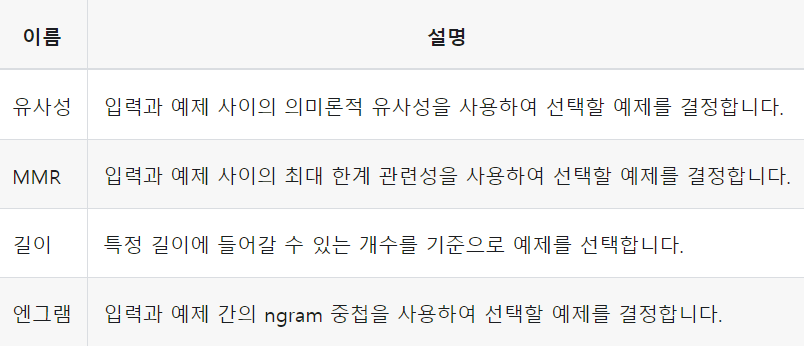


##### from langchain.prompts.example_selector 에서 선택가능하다.

## 예시 선택기
##### 예가 많은 경우 프롬프트에 포함할 예를 선택해야 할 수 있다.
##### 기본 인터페이스는 아래와 같은데, select_examples 메소드가 정의하면 된다.

```python
class BaseExampleSelector(ABC):
    """Interface for selecting examples to include in prompts."""

    @abstractmethod
    def select_examples(self, input_variables: Dict[str, str]) -> List[dict]:
        """Select which examples to use based on the inputs."""
        
    @abstractmethod
    def add_example(self, example: Dict[str, str]) -> Any:
        """Add new example to store."""
```

In [32]:
examples = [
    {"input": "hi", "output": "ciao"},
    {"input": "bye", "output": "arrivaderci"},
    {"input": "soccer", "output": "calcio"},
]

### 사용자 정의 예제
##### 단어의 길이에 따라 어떤 예를 선택할 지 선택하는 예시 선택기를 작성해보자

In [33]:
from langchain_core.example_selectors.base import BaseExampleSelector


class CustomExampleSelector(BaseExampleSelector):
    def __init__(self, examples):
        self.examples = examples

    def add_example(self, example):
        self.examples.append(example)

    def select_examples(self, input_variables):
        # This assumes knowledge that part of the input will be a 'text' key
        new_word = input_variables["input"]
        new_word_length = len(new_word)

        # Initialize variables to store the best match and its length difference
        best_match = None
        smallest_diff = float("inf")

        # Iterate through each example
        for example in self.examples:
            # Calculate the length difference with the first word of the example
            current_diff = abs(len(example["input"]) - new_word_length)

            # Update the best match if the current one is closer in length
            if current_diff < smallest_diff:
                smallest_diff = current_diff
                best_match = example

        return [best_match]

In [34]:
example_selector = CustomExampleSelector(examples)

In [35]:
example_selector.select_examples({"input": "okay"})

[{'input': 'bye', 'output': 'arrivaderci'}]

In [36]:
example_selector.add_example({"input": "hand", "output": "mano"})

In [37]:
example_selector.select_examples({"input": "okay"})

[{'input': 'hand', 'output': 'mano'}]

### 프롬프트에서 사용

In [38]:
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate

example_prompt = PromptTemplate.from_template("Input: {input} -> Output: {output}")

In [39]:
prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    suffix="Input: {input} -> Output:",
    prefix="Translate the following words from English to Italain:",
    input_variables=["input"],
)

print(prompt.format(input="word"))

Translate the following words from English to Italain:

Input: hand -> Output: mano

Input: word -> Output:


## 퓨샷 프롬프트 템플릿
##### 몇 번의 예제로 프롬프트 템플릿을 구성한다.


### 예제

In [40]:
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate

examples = [
    {
        "question": "Who lived longer, Muhammad Ali or Alan Turing?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali
""",
    },
    {
        "question": "When was the founder of craigslist born?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952
""",
    },
    {
        "question": "Who was the maternal grandfather of George Washington?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball
""",
    },
    {
        "question": "Are both the directors of Jaws and Casino Royale from the same country?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate Answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate Answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate Answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate Answer: New Zealand.
So the final answer is: No
""",
    },
]

##### 몇 예시를 문자열로 포맷팅

In [41]:
example_prompt = PromptTemplate(
    input_variables=["question", "answer"], template="Question: {question}\n{answer}"
)

print(example_prompt.format(**examples[0]))

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali



### FewShotPromptTemplate
##### FewShotPromptTemplate 객체 생성

In [42]:
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"],
)

print(prompt.format(input="Who was the father of Mary Ball Washington?"))

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali


Question: When was the founder of craigslist born?

Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952


Question: Who was the maternal grandfather of George Washington?

Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball W

### 예시 선택기를 사용
##### SemanticSimilarityExampleSelector : 입력과의 유사성을 기반으로 몇 장의 예시를 선택

In [ ]:
!pip install chromadb

In [ ]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    OpenAIEmbeddings(),
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    Chroma,
    # This is the number of examples to produce.
    k=1,
)

# Select the most similar example to the input.
question = "Who was the father of Mary Ball Washington?"
selected_examples = example_selector.select_examples({"question": question})
print(f"Examples most similar to the input: {question}")
for example in selected_examples:
    print("\n")
    for k, v in example.items():
        print(f"{k}: {v}")

In [ ]:
prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"],
)

print(prompt.format(input="Who was the father of Mary Ball Washington?"))

## chat_model에 대한 퓨샷 예시
##### 최적의 프롬프트 편집은 모델에 따라 다를 수 있고, FewShotChatMessagePromptTemplate을 사용하면 몇 개의 프롬프트 템플릿을 사용하고 원하는 대로 수정하거나 교체할 수 있다.

### 정적인 예시
##### 가장 기본적이고 일반적인 다중 프롬프트 기술은 고정된 프롬프트를 사용하는 것이다.
##### 템플릿의 기본 구성 요소는 아래와 같다.


*   examples : 최종 프롬프트에 포함할 사전 예제 목록
*   example_prompt : 해당 메소드를 통해 각 예제를 하나 이상의 메시지로 변환
*   format_messages : 인간 메시지와 함수 호출 메시지로 반환





In [46]:
from langchain.prompts import (
    ChatPromptTemplate,
    FewShotChatMessagePromptTemplate,
)

In [47]:
examples = [
    {"input": "2+2", "output": "4"},
    {"input": "2+3", "output": "5"},
]

In [48]:
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

print(few_shot_prompt.format())

Human: 2+2
AI: 4
Human: 2+3
AI: 5


In [49]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a wondrous wizard of math."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)

In [50]:
from langchain_openai import ChatOpenAI

chain = final_prompt | ChatOpenAI(temperature=0.0)

chain.invoke({"input": "What's the square of a triangle?"})

AIMessage(content='A triangle does not have a square. The square of a number is the result of multiplying the number by itself.', response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 52, 'total_tokens': 75}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

### 동적 퓨샷 프롬프트
##### 입력을 기반으로 표시되는 예제를 조건화할 때 동적 퓨샷 프롬프트를 사용한다.
##### 구성은 아래와 같다.


*   example_selector : 주어진 입력에 대해 몇 개의 예제를 선택하는 일을 담당한다. BaseEampelSelector 인터페이스를 구현(일반적으로 벡터스토어 기반 SemanticSimilarityExampleSelector)
*   example_prompt : 해당 메소드를 통해 각 예제를 하나 이상의 메시지로 변환
*   format_messages : 인간 메시지와 호출 메시지로 변환

##### 이를 다시 다른 메시지 및 채팅 템플릿과 함께 구성하여 최종 프롬프트를 구성할 수 있다.



In [51]:
from langchain.prompts import SemanticSimilarityExampleSelector
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [ ]:
examples = [
    {"input": "2+2", "output": "4"},
    {"input": "2+3", "output": "5"},
    {"input": "2+4", "output": "6"},
    {"input": "What did the cow say to the moon?", "output": "nothing at all"},
    {
        "input": "Write me a poem about the moon",
        "output": "One for the moon, and one for me, who are we to talk about the moon?",
    },
]

to_vectorize = [" ".join(example.values()) for example in examples]
embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_texts(to_vectorize, embeddings, metadatas=examples)

In [ ]:
example_selector = SemanticSimilarityExampleSelector(
    vectorstore=vectorstore,
    k=2,
)

# The prompt template will load examples by passing the input do the `select_examples` method
example_selector.select_examples({"input": "horse"})

##### 위에서 만든 example_selector를 프롬프트 템플릿에 넣는다.

In [ ]:
from langchain.prompts import (
    ChatPromptTemplate,
    FewShotChatMessagePromptTemplate,
)

# Define the few-shot prompt.
few_shot_prompt = FewShotChatMessagePromptTemplate(
    # The input variables select the values to pass to the example_selector
    input_variables=["input"],
    example_selector=example_selector,
    # Define how each example will be formatted.
    # In this case, each example will become 2 messages:
    # 1 human, and 1 AI
    example_prompt=ChatPromptTemplate.from_messages(
        [("human", "{input}"), ("ai", "{output}")]
    ),
)

##### 최종 프롬프트 템플릿 구성

In [ ]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a wondrous wizard of math."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)

##### LLM 모델과 함께 사용

In [ ]:
from langchain_community.chat_models import ChatAnthropic

chain = final_prompt | ChatAnthropic(temperature=0.0)

chain.invoke({"input": "What's 3+3?"})

## `MessagePromptTemplate`의 유형
##### AIMessagePromptTemplate : 가장 일반적으로 사용되는 AI 메시지
##### SystemMessagePromptTemplate : 시스템 메시지를 생성
##### HumanMessagePromptTemplate : 인간 메시지를 생성

In [53]:
from langchain.prompts import ChatMessagePromptTemplate

prompt = "May the {subject} be with you"

chat_message_prompt = ChatMessagePromptTemplate.from_template(
    role="Jedi", template=prompt
)
chat_message_prompt.format(subject="force")

ChatMessage(content='May the force be with you', role='Jedi')

##### 포맷 중 렌더링 할 메시지를 완전히 제어할 수 있는 MessagesPlaceholer를 제공한다.
##### 이는 메시지 프롬프트 템플릿에 어떤 역할을 사용해야 할지 확실하지 않거나 서식 지정 중에 메시지 목록을 삽입할려는 경우 유용하다.

In [54]:
from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

human_prompt = "Summarize our conversation so far in {word_count} words."
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

chat_prompt = ChatPromptTemplate.from_messages(
    [MessagesPlaceholder(variable_name="conversation"), human_message_template]
)

In [55]:
from langchain_core.messages import AIMessage, HumanMessage

human_message = HumanMessage(content="What is the best way to learn programming?")
ai_message = AIMessage(
    content="""\
1. Choose a programming language: Decide on a programming language that you want to learn.

2. Start with the basics: Familiarize yourself with the basic programming concepts such as variables, data types and control structures.

3. Practice, practice, practice: The best way to learn programming is through hands-on experience\
"""
)

chat_prompt.format_prompt(
    conversation=[human_message, ai_message], word_count="10"
).to_messages()

[HumanMessage(content='What is the best way to learn programming?'),
 AIMessage(content='1. Choose a programming language: Decide on a programming language that you want to learn.\n\n2. Start with the basics: Familiarize yourself with the basic programming concepts such as variables, data types and control structures.\n\n3. Practice, practice, practice: The best way to learn programming is through hands-on experience'),
 HumanMessage(content='Summarize our conversation so far in 10 words.')]

## 부분 프롬프트 템플릿
##### 필요한 값의 하위 집합을 전달하여 값의 나머지 하위 집합만 예상하는 새 프롬프트 템플릿을 생성하는 것이다.

### 문자열이 포함된 부분

In [56]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template("{foo}{bar}")
partial_prompt = prompt.partial(foo="foo")
print(partial_prompt.format(bar="baz"))

foobaz


In [57]:
prompt = PromptTemplate(
    template="{foo}{bar}", input_variables=["bar"], partial_variables={"foo": "foo"}
)
print(prompt.format(bar="baz"))

foobaz


### 함수를 부분적으로 사용할 경우

In [59]:
from datetime import datetime

def _get_datetime():
    now = datetime.now()
    return now.strftime("%m/%d/%Y, %H:%M:%S")

In [60]:
prompt = PromptTemplate(
    template="Tell me a {adjective} joke about the day {date}",
    input_variables=["adjective", "date"],
)
partial_prompt = prompt.partial(date=_get_datetime)
print(partial_prompt.format(adjective="funny"))

Tell me a funny joke about the day 04/01/2024, 09:19:47


##### 부분화된 변수를 사용하여 프롬프트 초기화 가능

In [61]:
prompt = PromptTemplate(
    template="Tell me a {adjective} joke about the day {date}",
    input_variables=["adjective"],
    partial_variables={"date": _get_datetime},
)
print(prompt.format(adjective="funny"))

Tell me a funny joke about the day 04/01/2024, 09:21:01


## 파이프라인
##### 여러 프롬프트를 함께 작성하자

In [62]:
from langchain.prompts.pipeline import PipelinePromptTemplate
from langchain.prompts.prompt import PromptTemplate

In [63]:
full_template = """{introduction}

{example}

{start}"""
full_prompt = PromptTemplate.from_template(full_template)

In [64]:
introduction_template = """You are impersonating {person}."""
introduction_prompt = PromptTemplate.from_template(introduction_template)

In [65]:
example_template = """Here's an example of an interaction:

Q: {example_q}
A: {example_a}"""
example_prompt = PromptTemplate.from_template(example_template)

In [66]:
start_template = """Now, do this for real!

Q: {input}
A:"""
start_prompt = PromptTemplate.from_template(start_template)

In [67]:
input_prompts = [
    ("introduction", introduction_prompt),
    ("example", example_prompt),
    ("start", start_prompt),
]
# PipelinePromptTemplate를 사용해서 여러 프롬프트를 합쳐서 사용
pipeline_prompt = PipelinePromptTemplate(
    final_prompt=full_prompt, pipeline_prompts=input_prompts
)

In [68]:
pipeline_prompt.input_variables

['input', 'example_q', 'person', 'example_a']

In [69]:
print(
    pipeline_prompt.format(
        person="Elon Musk",
        example_q="What's your favorite car?",
        example_a="Tesla",
        input="What's your favorite social media site?",
    )
)

You are impersonating Elon Musk.

Here's an example of an interaction:

Q: What's your favorite car?
A: Tesla

Now, do this for real!

Q: What's your favorite social media site?
A:
